In [1]:
# the aim is to end up with train, test, evaluate
import sys
sys.path.append("/Users/david/Documents/code/fhmm/v1")

In [2]:
import src.ads_davidjames9610.ads as ads
# import src.ads_davidjames9610.useful as useful
import numpy as np
import os
import os.path
from pathlib import Path
import matplotlib.pyplot as plt
from importlib import reload
import importlib
import src.classifiers_davidjames9610.test_a.config as base_config
reload(base_config)
config = importlib.import_module('src.classifiers_davidjames9610.test_a.whale_data.config')
reload(config)
print(config.basedir)
# import src.misc_davidjames9610.fe_methods as fe
# import src.misc_davidjames9610.proc_methods as pm

/Users/david/Documents/code/fhmm/v1/src/classifiers_davidjames9610/test_a/whale_data


In [3]:
import src.misc_davidjames9610.utils as utils
sls = utils.load_pickle(config.samples_labels)

In [10]:
# # going to have to do fe after cross-validation split
# import src.misc_davidjames9610.cross_validation as cv
# from src.misc_davidjames9610.cross_validation import *
import importlib
# importlib.reload(cv)
# from src.classifiers_davidjames9610.test_a import b_samples_to_features as feat_proc
# reload(feat_proc)
import src.misc_davidjames9610.noisey as noisey
reload(noisey)
import random

In [11]:
test_signals = utils.load_pickle(r'/Users/david/Documents/code/fhmm/v1/src/hmm_annots_davidjames9610/test_signals.pickle')

test_features = test_signals['test_features']
test_labels = test_signals['test_labels']
train_features = test_signals['train_features']
train_labels = test_signals['train_labels']
label_set = test_signals['label_set']
noise_sample_a = test_signals['noise_sample_a']
noise_sample_a_features = test_signals['noise_sample_a_features']
noise_sample_b = test_signals['noise_sample_b']

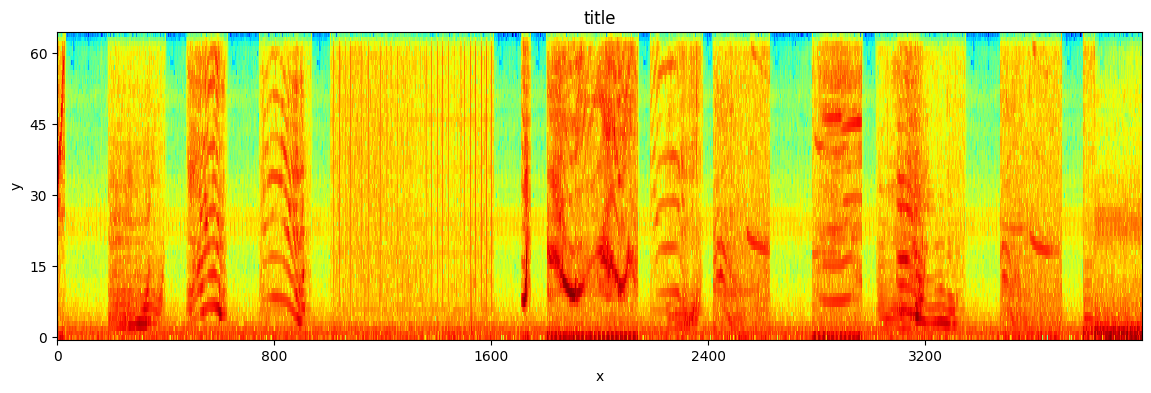

In [12]:
start_index = 11000
end_index = 15000
from spafe.utils import vis
vis.show_features(feats=test_features[start_index:end_index], title='title', ylabel='y', xlabel='x')
# plt.plot(test_labels[start_index:end_index])

In [45]:
# train classifier
from hmmlearn.hmm import GaussianHMM
import src.misc_davidjames9610.decode_combine as dc
import src.fhmm_davidjames9610.fhmm as fhmm
reload(fhmm)
import bnpy
import bnpy_utils
reload(bnpy_utils)

curr_features = train_features
curr_labels = train_labels
n_components = 8
# classifiers = {}
base_classifiers = {}
gaussian_classifiers = {}

# speaker = label_set[0]
for speaker in label_set:
    print('training for speaker: ', speaker)
    mask = (np.array(curr_labels) == speaker)
    mask = mask.tolist()
    speaker_features = [array for array, flag in zip(curr_features, mask) if flag]
    # speaker_features = np.array([item for sublist in speaker_features for item in sublist])
    train_for_whale_bnpy = bnpy_utils.get_GroupXData_from_list(speaker_features)
    bnpy_configs = {key: value for d in bnpy_utils.bnpy_config.values() for key, value in d.items()}
    goodelbopairs_trained_model, goodelbopairs_info_dict = bnpy.run(
        train_for_whale_bnpy, 'HDPHMM', 'DiagGauss', 'memoVB',
        output_path='/tmp/mocap6/trymerge-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye-merge_strategy=good_elbo_pairs/',
        moves='merge,shuffle', **bnpy_configs)
    curr_hmm = bnpy_utils.get_hmm_learn_from_bnpy(goodelbopairs_trained_model)
    base_classifiers[speaker] = curr_hmm

    gauss_hmm = GaussianHMM(n_components)
    gauss_hmm.fit(np.array([item for sublist in speaker_features for item in sublist]))
    gaussian_classifiers[speaker] = gauss_hmm


training for speaker:  0
Dataset Summary:
GroupXData
  total size: 38 units
  batch size: 38 units
  num. batches: 1
Allocation Model:  None
Obs. Data  Model:  Gaussian with diagonal covariance.
Obs. Data  Prior:  independent Gauss-Wishart prior on each dimension
  Wishart params 
    nu = 67  ...
  beta = [ 65  65]  ...
  Expectations
  E[  mean[k]] = 
  [ 0  0] ...
  E[ covar[k]] = 
  [[1. 0.]
   [0. 1.]] ...
Initialization:
  initname = randexamples
  K = 30 (number of clusters)
  seed = 1607680
  elapsed_time: 0.0 sec
Learn Alg: memoVB | task  1/1 | alg. seed: 1607680 | data order seed: 8541952
task_output_path: /tmp/mocap6/trymerge-K=20-model=HDPHMM+DiagGauss-ECovMat=1*eye-merge_strategy=good_elbo_pairs/1
MERGE @ lap 1.00: Disabled. Cannot plan merge on first lap. Need valid SS that represent whole dataset.
    1.000/100 after      0 sec. |    571.2 MiB | K   30 | loss  2.350823007e+00 |  
MERGE @ lap 2.00: Disabled. Waiting for lap >= 10 (--m_startLap).
    2.000/100 after      0

In [46]:
import na_hmm as na_hmm
reload(na_hmm)

my_na_hmm = na_hmm.NoiseAdaptiveHMM(
    base_classifiers=base_classifiers,
    noise_features=noise_sample_a_features,
    label_set=label_set,
    noise_hmm_components=4
)

my_na_hmm_gauss = na_hmm.NoiseAdaptiveHMM(
    base_classifiers=gaussian_classifiers,
    noise_features=noise_sample_a_features,
    label_set=label_set,
    noise_hmm_components=4
)

init noise adaptive hmm
init noise adaptive hmm


In [47]:
import src.misc_davidjames9610.utils as utils

_, predicted_labels, val_log_prob = my_na_hmm.dc_model.decode_hmmlearn(test_features[start_index:end_index])
performance_metrics = utils.get_performance_metrics(test_labels[start_index:end_index], predicted_labels, list(sls['num_to_label'].keys()))

print(performance_metrics['stats'])

_, predicted_labels, val_log_prob = my_na_hmm_gauss.dc_model.decode_hmmlearn(test_features[start_index:end_index])
performance_metrics = utils.get_performance_metrics(test_labels[start_index:end_index], predicted_labels, list(sls['num_to_label'].keys()))

print(performance_metrics['stats'])


{'precision': 0.9027889410846242, 'recall': 0.851, 'f1-score': 0.8693188669097291, 'support': 4000, 'acc': 0.851}
{'precision': 0.8995169056297716, 'recall': 0.871, 'f1-score': 0.8805562795218398, 'support': 4000, 'acc': 0.871}


In [26]:
# Define sliding window parameters
import na_hmm as na_hmm
reload(na_hmm)

window_size = 200
step_size = 50
test_start_index = start_index
test_end_index = end_index

out = na_hmm.sliding_windows(
    data=test_features[test_start_index:test_end_index],
    window_size=window_size,
    step_size=step_size,
    na_hmm=my_na_hmm,
    mean_log_prob=-25000,
    threshold=1.2)

windows_states = out['states']

performance_metrics = utils.get_performance_metrics(test_labels[test_start_index:test_end_index], windows_states, list(sls['num_to_label'].keys()))

print(performance_metrics['stats'])

{'precision': 0.9111444446536489, 'recall': 0.8855, 'f1-score': 0.8939063073802863, 'support': 4000, 'acc': 0.8855}
